In [ ]:
cd /content

/content


In [ ]:
!ls


sample_data


In [ ]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

Cloning into 'google-colab-cs231n'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 5.07 MiB | 19.09 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [ ]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
get_datasets.sh


In [ ]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [ ]:
!./get_datasets.sh

--2022-03-13 10:48:09--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  97.3MB/s    in 1.7s    

2022-03-13 10:48:10 (97.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2


import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


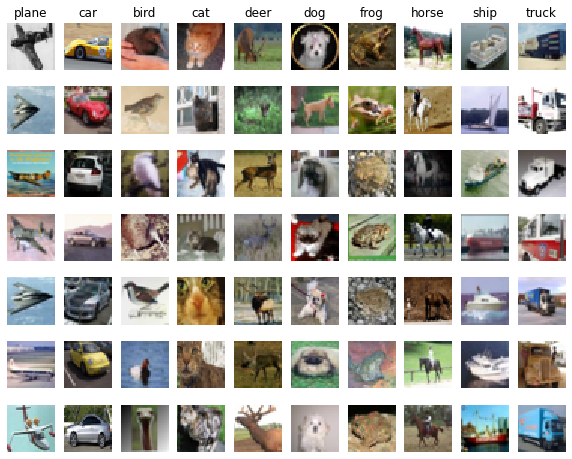

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


In [ ]:
pretty_print(classifier.compute_distances_two_loops)

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        dists[i, j] = np.linalg.norm(X[i]-self.X_train[j])

    return dists

(500, 5000)


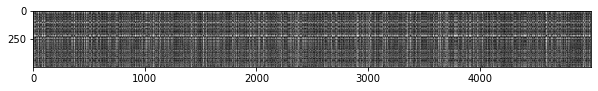

In [ ]:
plt.imshow(dists, interpolation='none')
plt.show()

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


In [ ]:
pretty_print(classifier.compute_distances_one_loop)

dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      # Note axis=1 computes norm along rows
      dists[i] = np.linalg.norm(X[i]-self.X_train, axis=1)

    return dists

Difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
pretty_print(classifier.compute_distances_no_loops)

dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]

    # Expand ||x - y||**2 = ||x||**2 - 2 x.T ⋅y + ||y||**2,
    # where ||x||**2 = sum(x**2) (element-wise on matrix rows)
    # The final result is a (num_test, num_train) matrix
    # so the x**2 and y**2 intermediates must be reshaped appropriately
    x2 = np.sum(X**2, axis=1).reshape((num_test, 1))
    y2 = np.sum(self.X_train**2, axis=1).reshape((1, num_train))
    xy = -2*np.matmul(X, self.X_train.T)
    dists = np.sqrt(x2 + xy + y2)

    return dists

Difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 32.482410 seconds
One loop version took 40.705465 seconds
No loop version took 0.563779 seconds


In [ ]:
num_folds = 5
k_choices = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

if num_training/num_folds % num_folds != 0.0:
    raise ValueError('Number of training examples not evenly divisible by number of folds.')

X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []
    
for idx in range(num_folds):
    X_train_set = np.concatenate((*X_train_folds[:idx], *X_train_folds[idx+1:]), axis=0)
    y_train_set = np.concatenate((*y_train_folds[:idx], *y_train_folds[idx+1:]), axis=0)
    X_validation_set = X_train_folds[idx]
    y_validation_set = y_train_folds[idx]   
    num_validation_set = X_validation_set.shape[0]
    # Train kNN classifier
    classifier = KNearestNeighbor()
    classifier.train(X_train_set, y_train_set)
    # Compute distances
    dists_validate = classifier.compute_distances_no_loops(X_validation_set)
    for k in k_choices:
        y_validation_pred = classifier.predict_labels(dists_validate, k=k)
        # Check accuracy
        accuracy = (float(np.sum(np.equal(y_validation_pred, y_validation_set)))/num_validation_set)
        k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 2, accuracy = 0.235000
k = 2, accuracy = 0.219000
k = 2, accuracy = 0.234000
k = 2, accuracy = 0.247000
k = 2, accuracy = 0.252000
k = 4, accuracy = 0.259000
k = 4, accuracy = 0.270000
k = 4, accuracy = 0.269000
k = 4, accuracy = 0.294000
k = 4, accuracy = 0.272000
k = 6, accuracy = 0.253000
k = 6, accuracy = 0.277000
k = 6, accuracy = 0.274000
k = 6, accuracy = 0.273000
k = 6, accuracy = 0.282000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 14, accuracy = 0.263000
k = 14, accuracy 

k = 1, average accuracy = 0.265600
k = 2, average accuracy = 0.237400
k = 4, average accuracy = 0.272800
k = 6, average accuracy = 0.271800
k = 8, average accuracy = 0.276000
k = 10, average accuracy = 0.280200
k = 12, average accuracy = 0.279400
k = 14, average accuracy = 0.282000
k = 16, average accuracy = 0.275600
k = 18, average accuracy = 0.277600
k = 20, average accuracy = 0.279000


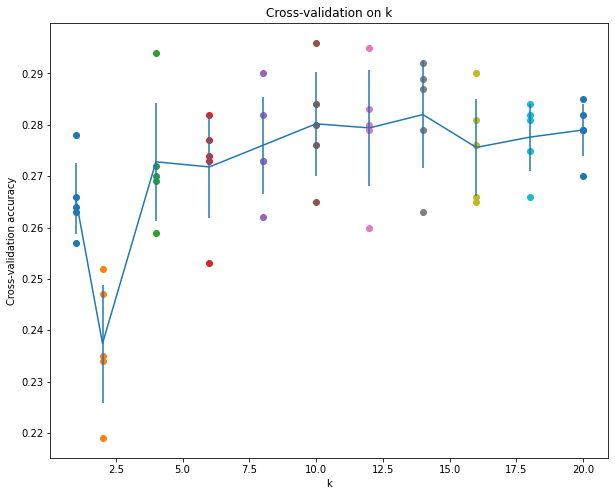

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    print('k = %d, average accuracy = %f' % (k, np.average(accuracies)))
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# data. Get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


# **K-NN:**
The function is only approximated locally in k-NN classification, and all computation is postponed until the function is evaluated. Because this method relies on distance for classification, normalizing the training data can greatly increase its performance if the features represent various physical units or come in wildly different scales.

# **Applications:**
Some application of KNN algorithm are-
Currency exchange rate,Bank bankruptcies,Understanding and managing,financial risk,Trading futures,Credit rating,Loan management etc.

When it comes to picture classification, KNN isn't very good. KNN does not go into detail about certain class attributes. It only looks for differences in pixel values, not features. KNN performs better with data that has columns as attributes, with each attribute defining a distinct feature. In the case of an image, however, each pixel value does not define a specific characteristic. The accuracy of this technique is also dependent on the data quality. With a lot of data, the prediction stage could take a long time. Sensitive to the size of the data and attributes that aren't relevant.So KNN is bad for image classification.
